<a href="https://colab.research.google.com/github/Atlantxyz/ml/blob/main/%D0%A2%D0%B5%D0%BC%D0%B0%207/assignment07_unsupervised_learning%20(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Домашнее задание № 7
## <center> Обучение без учителя: метод главных компонент и кластеризация

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use("dark_background")

# print(plt.style.available)

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
samsung_test = "https://raw.githubusercontent.com/Atlantxyz/ml/refs/heads/main/%D0%A2%D0%B5%D0%BC%D0%B0%207/samsung_test.txt"
samsung_test_labels = "https://raw.githubusercontent.com/Atlantxyz/ml/refs/heads/main/%D0%A2%D0%B5%D0%BC%D0%B0%207/samsung_test_labels.txt"
samsung_train = "https://raw.githubusercontent.com/Atlantxyz/ml/refs/heads/main/%D0%A2%D0%B5%D0%BC%D0%B0%207/samsung_train.txt"
samsung_train_labels = "https://raw.githubusercontent.com/Atlantxyz/ml/refs/heads/main/%D0%A2%D0%B5%D0%BC%D0%B0%207/samsung_train_labels.txt"

X_train = np.loadtxt(samsung_train)
y_train = np.loadtxt(samsung_train_labels).astype(int)

X_test = np.loadtxt(samsung_test)
y_test = np.loadtxt(samsung_test_labels).astype(int)

In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [4]:
# Ваш код здесь
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))

Определим число уникальных значений меток целевого класса.

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [6]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [7]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [8]:
# Ваш код здесь
pca = PCA(n_components=0.90, random_state=RANDOM_STATE)  # Сохраняем компоненты, объясняющие 90% дисперсии
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [9]:
# Ваш код здесь
n_components = pca.n_components_
print(f"Варианты ответа: 56, 65, 66, 193. Наш результат: {n_components}")

Варианты ответа: 56, 65, 66, 193. Наш результат: 65


**Варианты:**
- 56
- 65 - верный
- 66
- 193

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- 51 - верный
- 56
- 61

In [10]:
# Процент дисперсии для первой главной компоненты
variance_first_component = pca.explained_variance_ratio_[0] * 100
print(f"Процент дисперсии для первой главной компоненты: {variance_first_component:.0f}%")


Процент дисперсии для первой главной компоненты: 51%


Визуализируйте данные в проекции на первые две главные компоненты.

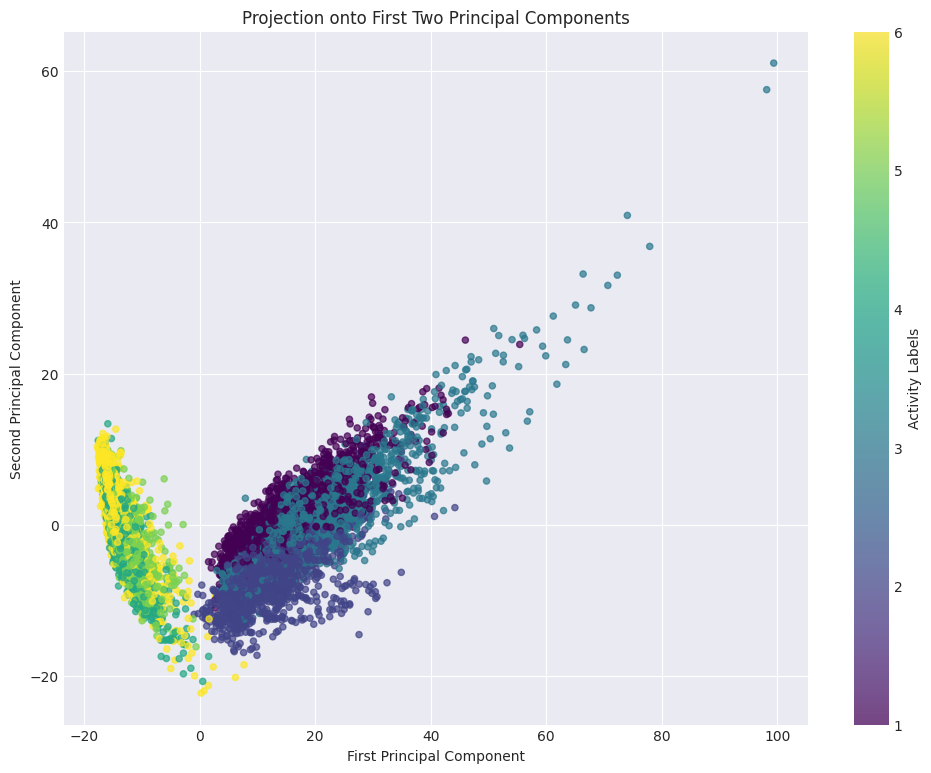

In [11]:
# Визуализация в проекции на первые две главные компоненты
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis', alpha=0.7)
plt.colorbar(label='Activity Labels')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Projection onto First Two Principal Components')
plt.show()

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание) - верный
- 6 кластеров

------------------------------

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

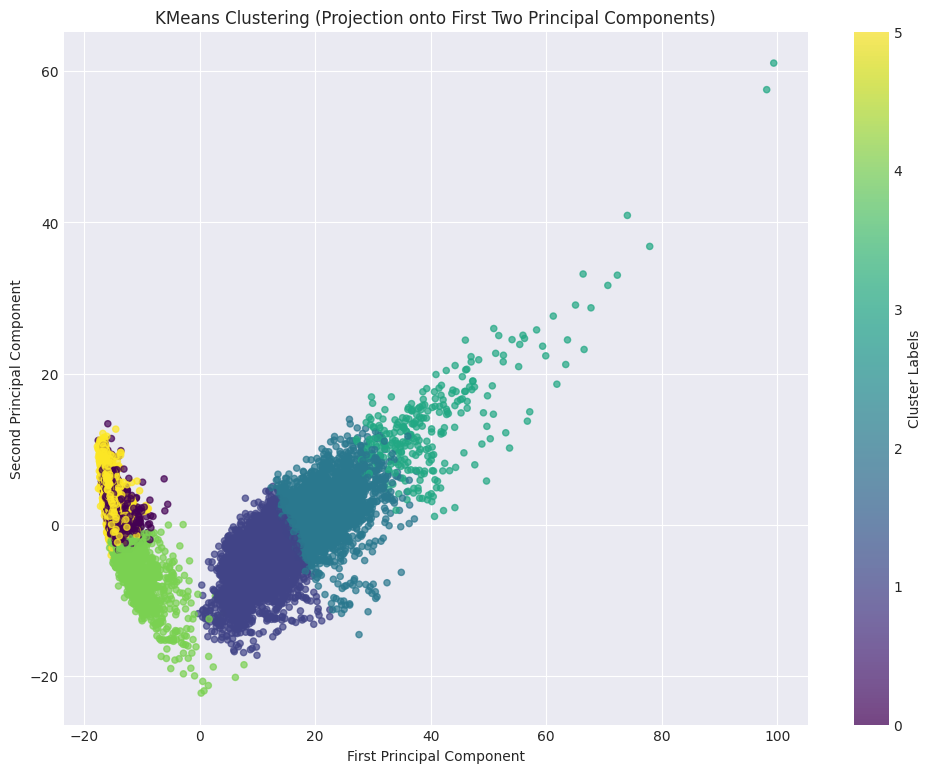

In [12]:
from sklearn.cluster import KMeans

# Число уникальных меток целевого класса
n_classes = len(np.unique(y))

# Настройка KMeans
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
cluster_labels = kmeans.fit_predict(X_pca)

# Визуализация результатов кластеризации
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis', alpha=0.7)
plt.colorbar(label='Cluster Labels')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('KMeans Clustering (Projection onto First Two Principal Components)')
plt.show()


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

In [13]:
# Таблица соответствия
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(n_classes)] + ['все']
print(tab)


                          cluster1  cluster2  cluster3  cluster4  cluster5  \
ходьба                           0       903       741        78         0   
подъем вверх по лестнице         0      1241       296         5         2   
спуск по лестнице                0       320       890       196         0   
сидение                       1235         1         0         0       450   
стояние                       1344         0         0         0       562   
лежание                         52         5         0         0       329   
все                           2631      2470      1927       279      1343   

                          cluster6    все  
ходьба                           0   1722  
подъем вверх по лестнице         0   1544  
спуск по лестнице                0   1406  
сидение                         91   1777  
стояние                          0   1906  
лежание                       1558   1944  
все                           1649  10299  


Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [14]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,741,78,0,0,1722
подъем вверх по лестнице,0,1241,296,5,2,0,1544
спуск по лестнице,0,320,890,196,0,0,1406
сидение,1235,1,0,0,450,91,1777
стояние,1344,0,0,0,562,0,1906
лежание,52,5,0,0,329,1558,1944
все,2631,2470,1927,279,1343,1649,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние - верный
- спуск по лестнице
- перечисленные варианты не подходят

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

  0%|          | 0/6 [00:00<?, ?it/s]

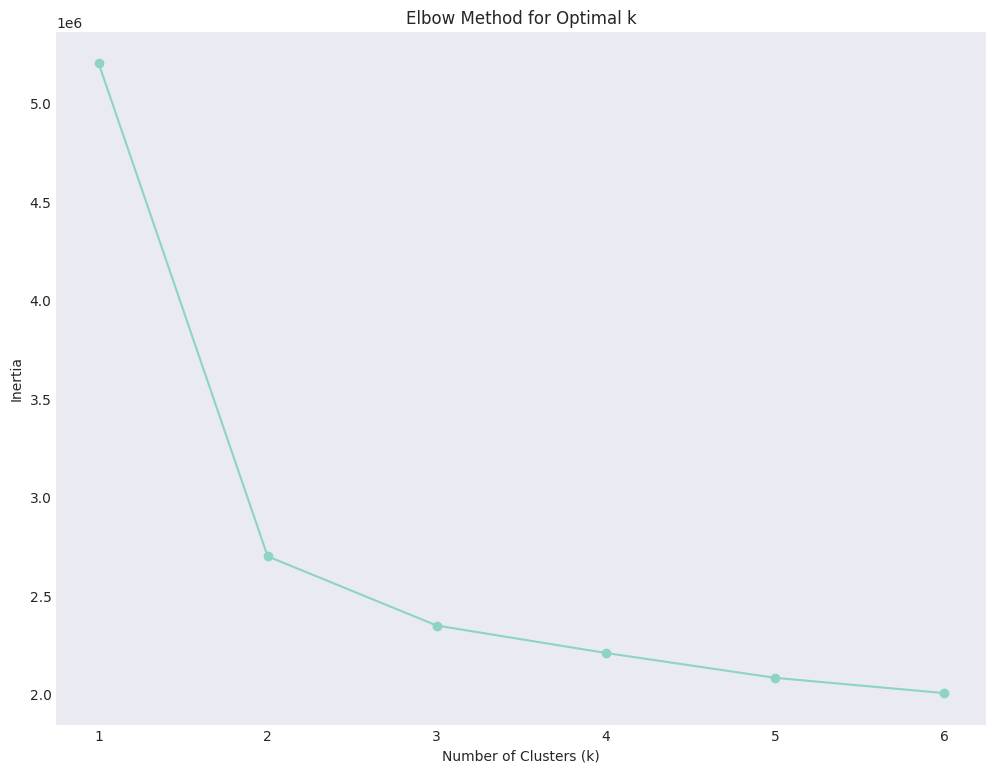

In [15]:
from tqdm.notebook import tqdm  # Импорт tqdm_notebook

# Подсчет значения inertia для различных n_clusters
inertia = []
for k in tqdm(range(1, n_classes + 1)):  # Перебираем от 1 до n_classes кластеров
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Визуализация метода локтя
plt.plot(range(1, n_classes + 1), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()


**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3 - верный
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [16]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [17]:
from sklearn.metrics import adjusted_rand_score

# Агломеративная кластеризация
ag = AgglomerativeClustering(n_clusters=n_classes, linkage='ward')
ag_labels = ag.fit_predict(X_pca)

# Adjusted Rand Index для KMeans
kmeans_ari = adjusted_rand_score(y, cluster_labels)

# Adjusted Rand Index для агломеративной кластеризации
ag_ari = adjusted_rand_score(y, ag_labels)

print(f"Adjusted Rand Index для KMeans: {kmeans_ari:.4f}")
print(f"Adjusted Rand Index для агломеративной кластеризации: {ag_ari:.4f}")


Adjusted Rand Index для KMeans: 0.4198
Adjusted Rand Index для агломеративной кластеризации: 0.4936


**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering - верный
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю - верный

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [18]:
# Ваш код здесь
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [20]:
# Ваш код здесь
grid_svc = GridSearchCV(svc, svc_params, cv=3, scoring='accuracy', verbose=1)
grid_svc.fit(X_train_scaled, y_train)

best_svc = grid_svc.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [21]:
print(f"Лучший параметр C: {grid_svc.best_params_['C']}")
print(f"Лучшая точность на обучении (cv): {grid_svc.best_score_:.4f}")

# Оценка на тестовой выборке
test_accuracy = best_svc.score(X_test_scaled, y_test)
print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

Лучший параметр C: 0.1
Лучшая точность на обучении (cv): 0.9380
Точность на тестовой выборке: 0.9620


**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1 - верный
- 1
- 10

In [22]:
y_predicted = best_svc.predict(X_test_scaled)

In [23]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:**<br>
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение - верный
- по точности – ходьба, по полноте – ходьба
- по точности – сидение, по полноте – стояние

In [24]:
# Анализ точности и полноты
from sklearn.metrics import classification_report

report = classification_report(y_test, y_predicted, target_names=tab.index[:-1])
print("Отчет классификации:\n", report)

Отчет классификации:
                           precision    recall  f1-score   support

                  ходьба       0.97      1.00      0.98       496
подъем вверх по лестнице       0.98      0.97      0.98       471
       спуск по лестнице       1.00      0.98      0.99       420
                 сидение       0.96      0.87      0.91       491
                 стояние       0.88      0.97      0.92       532
                 лежание       1.00      0.98      0.99       537

                accuracy                           0.96      2947
               macro avg       0.97      0.96      0.96      2947
            weighted avg       0.96      0.96      0.96      2947



Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4% - верный
- 10%
- 20%


In [25]:
# Вопрос 9: PCA и классификация
# Обучение PCA на обучающей выборке
pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Настройка GridSearchCV с PCA-преобразованием
grid_svc_pca = GridSearchCV(svc, svc_params, cv=3, scoring='accuracy', verbose=1)
grid_svc_pca.fit(X_train_pca, y_train)

# Лучшая точность и параметр C для PCA
best_svc_pca = grid_svc_pca.best_estimator_
best_cv_score_pca = grid_svc_pca.best_score_

print(f"Лучший параметр C с PCA: {grid_svc_pca.best_params_['C']}")
print(f"Лучшая точность на кросс-валидации с PCA: {best_cv_score_pca:.4f}")

# Оценка на тестовой выборке с PCA
test_accuracy_pca = best_svc_pca.score(X_test_pca, y_test)
print(f"Точность на тестовой выборке с PCA: {test_accuracy_pca:.4f}")

# Разница в качестве
quality_difference = grid_svc.best_score_ - best_cv_score_pca
print(f"Разница в качестве (доля верных ответов): {quality_difference:.4f}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Лучший параметр C с PCA: 0.1
Лучшая точность на кросс-валидации с PCA: 0.8991
Точность на тестовой выборке с PCA: 0.9213
Разница в качестве (доля верных ответов): 0.0389


**Вопрос 10:**<br>
Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность - верный
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком - верный